__In this notebook, we are going to build a time series model to predict the future price of bitcoin, which can be very useful for traders. For this purpose, we use the historical bitcoin price data for 8 years (from 2017 to 2023).__

### Let's get started:

# Step 1: Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

# Step 2: Reading Dataset

In [7]:
df = pd.read_csv('/kaggle/input/bitcoin-price/bitcoin_2017_to_2023.csv')

# Step 3: Dataset Overview

In [8]:
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


__As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.__

__Dataset Basic Information:__

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3126000 entries, 0 to 3125999
Data columns (total 10 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   timestamp                     object 
 1   open                          float64
 2   high                          float64
 3   low                           float64
 4   close                         float64
 5   volume                        float64
 6   quote_asset_volume            float64
 7   number_of_trades              int64  
 8   taker_buy_base_asset_volume   float64
 9   taker_buy_quote_asset_volume  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 238.5+ MB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [9]:
df.drop(['volume', 'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume'], axis=1, inplace=True)

In [10]:
df.head()

,timestamp,open,high,low,close
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41


In [23]:
import datetime


# сгруппировала данные по дням, т.к. очень большой объем, мой комп не справляется

df=df.groupby('timestamp',as_index=False).mean().sort_values('timestamp', ascending=False)
df.head()

,timestamp,open,high,low,close
2175,2023-08-01,28967.925800,28971.070525,28963.672375,28967.510575
2174,2023-07-31,29333.320083,29336.401674,29329.996542,29333.285931
2173,2023-07-30,29303.041097,29304.852167,29301.130729,29302.991097
2172,2023-07-29,29327.994139,29328.955569,29327.099979,29328.020958
2171,2023-07-28,29268.979965,29271.873049,29266.274403,29269.043722


## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [29]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2176 entries, 2175 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2176 non-null   datetime64[ns]
 1   open       2176 non-null   float64       
 2   high       2176 non-null   float64       
 3   low        2176 non-null   float64       
 4   close      2176 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 102.0 KB


__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [32]:
NumCols = df.columns.drop(['timestamp'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [33]:
df.head()

,timestamp,open,high,low,close
2175,2023-08-01,28967.925800,28971.070525,28963.672375,28967.510575
2174,2023-07-31,29333.320083,29336.401674,29329.996542,29333.285931
2173,2023-07-30,29303.041097,29304.852167,29301.130729,29302.991097
2172,2023-07-29,29327.994139,29328.955569,29327.099979,29328.020958
2171,2023-07-28,29268.979965,29271.873049,29266.274403,29269.043722


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [34]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [35]:
df.isnull().sum().sum()

0

# Step 5: Visualizing Bitcoin Price History Data

__Interactive Gold Price Chart:__

In [61]:
fig = px.line(y=df.close, x=df.timestamp)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="timestamp", 
                  yaxis_title="Scaled Price",
                  title={'text': "BitCoin Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [37]:
test_size = df[df.timestamp.dt.year==2023].shape[0]
test_size

213

__Bitcoin Price Training and Test Sets Plot:__

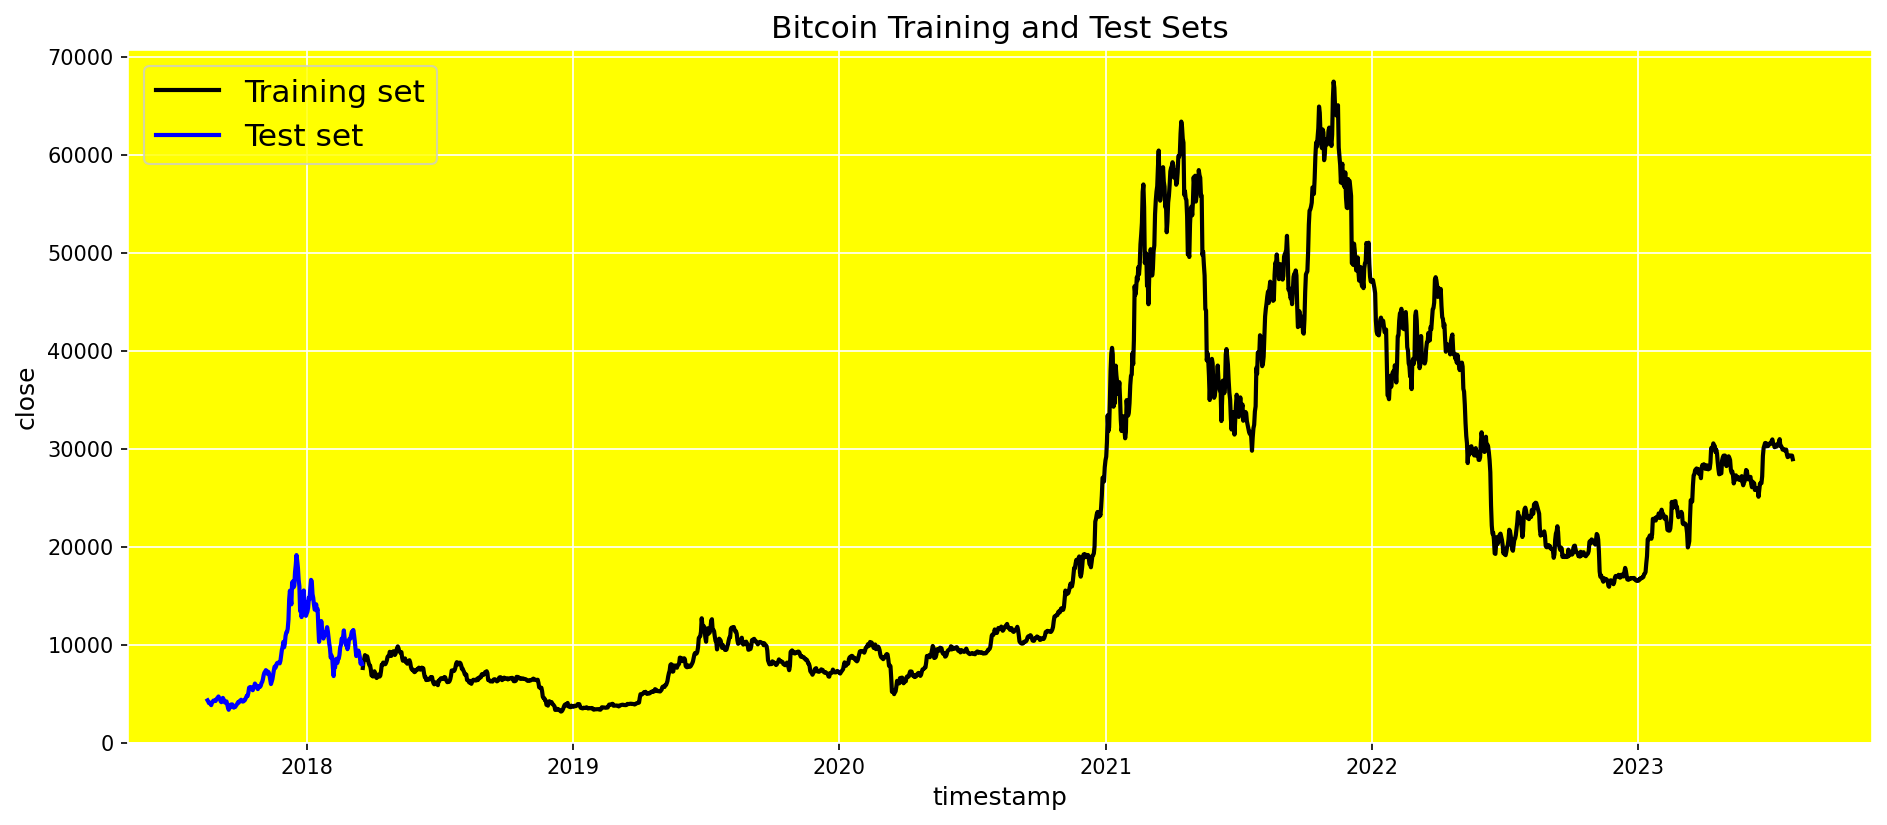

In [38]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.timestamp[:-test_size], df.close[:-test_size], color='black', lw=2)
plt.plot(df.timestamp[-test_size:], df.close[-test_size:], color='blue', lw=2)
plt.title('Bitcoin Training and Test Sets', fontsize=15)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('close', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [39]:
scaler = MinMaxScaler()
scaler.fit(df.close.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of bitcoin prices containing the next day's bitcoin price corresponds to each list in X_train and X_test respectively:__

In [40]:
window_size = 60

__Training Set:__

In [42]:
train_data = df.close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [43]:
train_data

array([[0.4006215 ],
       [0.40631133],
       [0.40584008],
       ...,
       [0.08400297],
       [0.07969005],
       [0.06924546]])

In [44]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [45]:
df.close

2175    28967.510575
2174    29333.285931
2173    29302.991097
2172    29328.020958
2171    29269.043722
            ...     
4        4035.014465
3        4123.014063
2        4070.712250
1        4230.951715
0        4358.630667
Name: close, Length: 2176, dtype: float64

In [47]:
test_data = df.close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [48]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [49]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [50]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [51]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1903, 60, 1)
y_train Shape:  (1903, 1)
X_test Shape:   (213, 60, 1)
y_test Shape:   (213, 1)


# Step 10: Creating an LSTM Network 
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [141]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
#     x = Dropout(0.25)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
#     x = Dropout(0.25)(x)
    x = LSTM(units = 64)(x)
#     x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Adam')
#     mean_squared_error
    model.summary()
    
    return model

__Model Training:__

In [142]:
model = define_model()
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,169 (340.50 KB)

 Trainable params: 87,169 (340.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0415 - val_loss: 2.7907e-04
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0029 - val_loss: 1.3987e-04
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0020 - val_loss: 1.3914e-04
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0020 - val_loss: 1.6648e-04
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0018 - val_loss: 1.0832e-04
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0015 - val_loss: 1.0973e-04
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0014 - val_loss: 9.6818e-05
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0014 - val_loss: 1.2242e-04
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0012 - val_loss: 1.5039e-04
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0015 - val_loss: 8.1349e-05
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0012 - val_loss: 7.1768e-05
Epoch 12/15
54/54 

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [143]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.4411e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [144]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [145]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00036180319148115814
Test MAPE: 0.18955033121916748
Test Accuracy: 0.8104496687808325


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [57]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

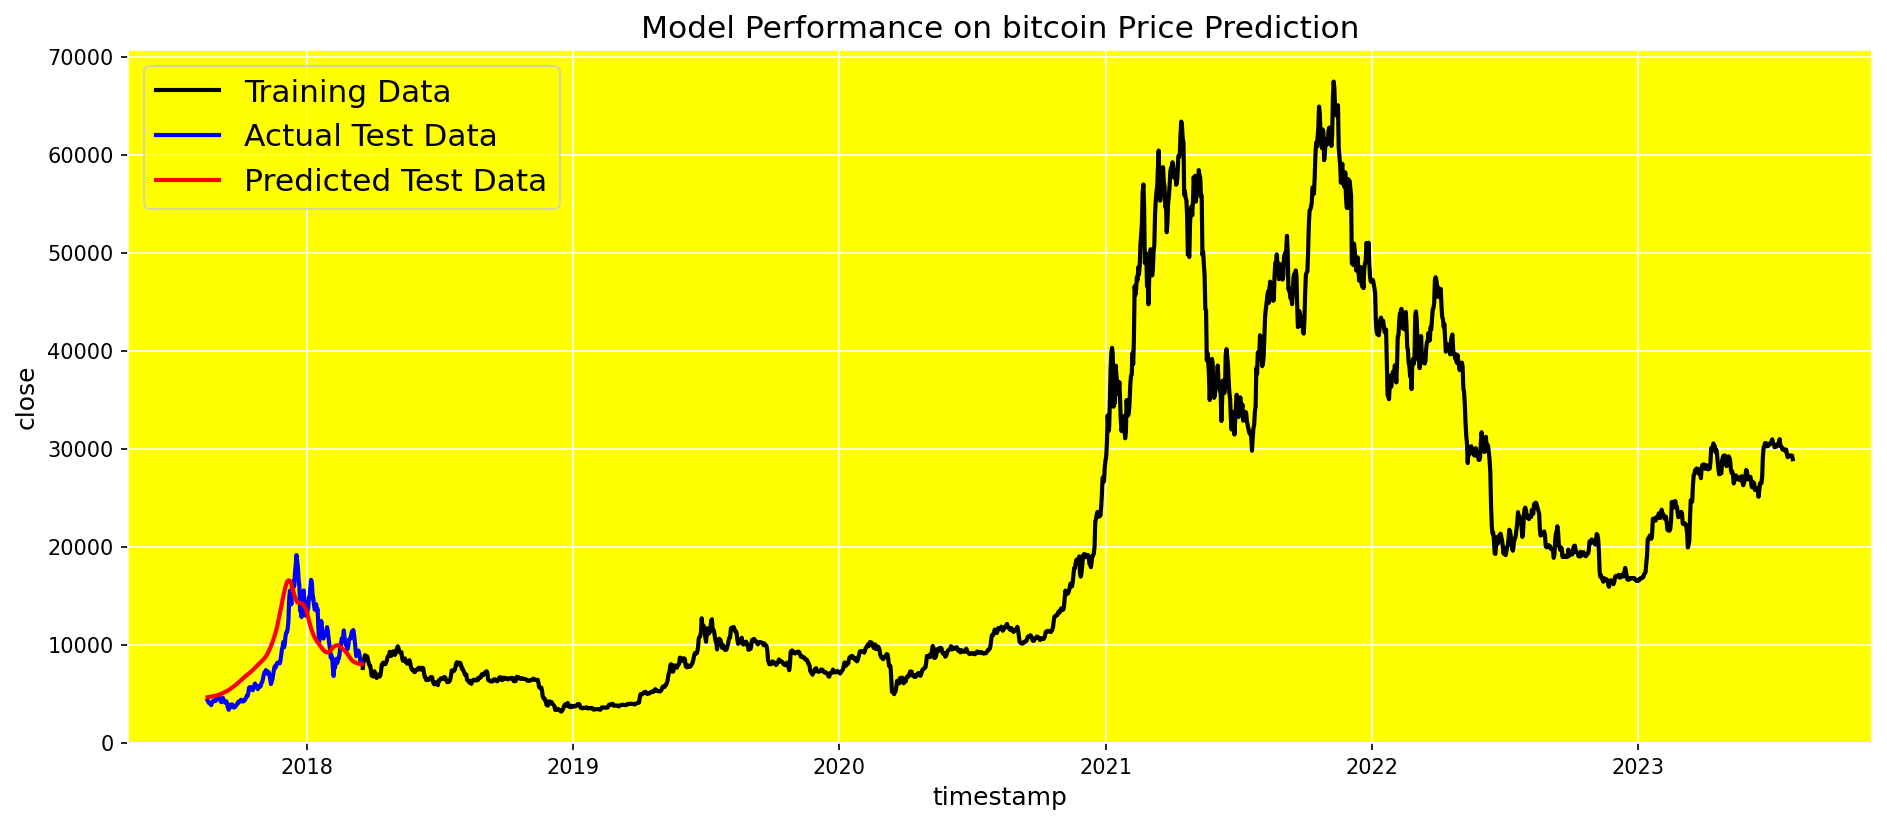

In [60]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['timestamp'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['timestamp'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['timestamp'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on bitcoin Price Prediction', fontsize=15)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('close', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()